# How Does Batch Normalization Work? Part 2


In [Part 1](https://blog.vikrampawar.com/how-batchnorm-works.html), we saw that batch normalization (BN) can help train neural networks by reducing internal covariate shift (ICS) and smoothing gradient updates. We measured ICS as distributional shift in layer activations, in line with Ioffe and Szegedy (2015). For a fully-connected network with 4 layers, we observed that the activation distributions with BN were comparatively stable compared to those for the network without BN.  We also touched upon the idea that BN has a smoothing effect on the loss surface, making it more convex.

In their 2018 paper, [Santurkar et al.](https://arxiv.org/pdf/1805.11604) argued that the reduction in internal covariate shift due to BN is marginal at best, and might even increase it. Additionally:

- BN improves training performance even when random noise is added to the layer activations, forcing ICS. Therefore, ICS is independent of the effectiveness of BN.
- Using a new, gradient-based definition of ICS, they showed that BN has no substantial effect on it, and might even increase it.
- The effectiveness of BN, including other desirable effects like preventing vanishing/exploding gradients as well as robustness to initialization and hyperparameter choices are merely downstream effects of an underlying set of causes:
    - Lower Lipschitzness of the (i.e. smoother) loss surface.
    - Lower Lipschitzness of the gradients i.e. better gradient predictiveness and consequently, higher "effective" $\beta$-smoothness of the gradients.
    - More favourable initialization.

In this experiment, we will attempt to reproduce some of these findings.

In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !mkdir /backend-container
    !mkdir /backend-container/containers
    !touch /backend-container/containers/build.constraints
    !touch /backend-container/containers/requirements.constraints
    !git clone https://github.com/novastar53/deepkit
    #!git checkout 0957acdf4a007350a5f393f6777765b637ec8739
    !cd deepkit && uv build . --wheel --prerelease allow && pip uninstall deepkit -y && pip install ./dist/* --quiet
else:
    import sys
    from pathlib import Path
    package_path = Path("../../deepkit/src").resolve()
    if str(package_path) not in sys.path:
        sys.path.append(str(package_path))



Cloning into 'deepkit'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 210 (delta 111), reused 167 (delta 72), pack-reused 0 (from 0)
Receiving objects: 100% (210/210), 63.29 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Branch 'santurkar-ics' set up to track remote branch 'santurkar-ics' from 'origin'.
Switched to a new branch 'santurkar-ics'
running egg_info
creating src/deepkit.egg-info
writing src/deepkit.egg-info/PKG-INFO
writing dependency_links to src/deepkit.egg-info/dependency_links.txt
writing requirements to src/deepkit.egg-info/requires.txt
writing top-level names to src/deepkit.egg-info/top_level.txt
writing manifest file 'src/deepkit.egg-info/SOURCES.txt'
reading manifest file 'src/deepkit.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'src/deepkit.egg-info/SOURCES.txt'
running bdist_wheel
running build
running build_py
cre

## Let's Start by Downloading and Preprocessing the Dataset.
The CIFAR-10 dataset includes 60,000 color images of size 32×32 pixels, divided into 50,000 training images and 10,000 testing images. The dataset is organized into ten distinct classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

To save some space, I have written a CIFAR-10 [dataloader](https://github.com/novastar53/deepkit/blob/main/src/deepkit/datasets.py) which downloads and performs standard preprocessing (normalization and augmentation). For this experiment, we will not augment the dataset.

In [2]:
from deepkit.datasets import load_CIFAR10

train_loader, test_loader = load_CIFAR10(augment=False)

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(
100%|██████████| 170M/170M [00:01<00:00, 106MB/s]



## Let's Set Up the Baseline and Candidate Models
We'll be using a VGG-Net style network with 10 3x3 convolutional and 3 FC layers including the final classifier. The activations are ReLU. The candidate model has a BatchNorm layer after each convolutional layer. The weights for both networks are initialized using the Glorot/Xavier method, which is standard for convolutional networks. To simplify our analysis, we will not use any regularization like dropout or weight decay.

In [3]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx

kernel_init = nnx.initializers.glorot_normal()


class VGGBlock(nnx.Module):
    def __init__(self, in_features: int, out_features: int, rngs: nnx.Rngs):
        self.conv = nnx.Conv(in_features=in_features,
                             out_features=out_features,
                             kernel_size=(3, 3),
                             kernel_init=kernel_init,
                             padding='SAME',
                             rngs=rngs)
        self.bn = nnx.BatchNorm(num_features=out_features, momentum=0.90, rngs=rngs)

    def __call__(self, x):
        x = self.conv(x)
        x = self.bn(x)
        conv_activation = x
        x = nnx.relu(x)
        return x, conv_activation

class VGGNet(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.convs = [
            VGGBlock(in_features=3, out_features=64,  rngs=rngs),
            VGGBlock(in_features=64, out_features=64,  rngs=rngs),

            VGGBlock(in_features=64, out_features=128, rngs=rngs),
            VGGBlock(in_features=128, out_features=128, rngs=rngs),

            VGGBlock(in_features=128, out_features=256, rngs=rngs),
            VGGBlock(in_features=256, out_features=256, rngs=rngs),

            VGGBlock(in_features=256, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),

            VGGBlock(in_features=512, out_features=512, rngs=rngs),
            VGGBlock(in_features=512, out_features=512, rngs=rngs),
        ]

        self.fc1 = nnx.Linear(in_features=512, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.fc2 = nnx.Linear(in_features=96, out_features=96, kernel_init=kernel_init, rngs=rngs)
        self.out = nnx.Linear(in_features=96, out_features=10,  kernel_init=kernel_init, rngs=rngs)

    def __call__(self, x):
        activations = {}
        max_pool_after = [1, 3, 5, 7, 9]
        for conv_idx in range(len(self.convs)):
            layer = self.convs[conv_idx]
            x, act = layer(x)
            activations[f"conv_{conv_idx}"] = act
            if conv_idx in max_pool_after:
                x = nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.squeeze()

        x = self.fc1(x)
        activations["fc1"] = x
        x = nnx.relu(x)

        x = self.fc2(x)
        activations["fc2"] = x
        x = nnx.relu(x)

        x = self.out(x)
        activations["out"] = x
        return x, activations

Let's initialize the baseline (non-BN) and candidate (BN) models. Both networks are initialized with the same random key for consistency and reproducibility. Both networks have roughly 9.5 million paramters.


In [4]:
rng_key = jax.random.key(1337)
rngs = nnx.Rngs(rng_key)
candidate = VGGNet(rngs=rngs)
candidate_graphdef, candidate_state = nnx.split(candidate)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size,
                                                                    candidate_state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(candidate_state)

Initialized model with 9,476,298 parameters.


The Flax-NNX library makes it quite easy to modify models. To remove the BN layers, we can simply set them to the identity function.

In [5]:
rng_key = jax.random.key(1337)
rngs = nnx.Rngs(rng_key)
baseline = VGGNet(rngs=rngs)

# Remove the batchnorm layers
for vgg in baseline.convs:
  vgg.bn = lambda x: x

baseline_graphdef, baseline_state = nnx.split(baseline)
param_counts = sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size,
                                                                    baseline_state)))
print(f"Initialized model with {param_counts:,} parameters.")
nnx.display(baseline_state)

Initialized model with 9,464,522 parameters.


We'll be using standard stochastic gradient descent with momentum to simplify the analysis and isolate the effects of batch normalization. The learning rate is tuned to be as high as can be sustained by the non-BN network without diverging.

In [6]:
import optax

lr = 0.035
momentum = 0.9

baseline_optimizer = nnx.Optimizer(baseline, optax.sgd(learning_rate=lr, momentum=momentum,
                                                       nesterov=False))
candidate_optimizer = nnx.Optimizer(candidate, optax.sgd(learning_rate=lr, momentum=momentum,
                                                         nesterov=False))

The loss is measured using cross-entropy, which is standard for multi-label classification. Accuracy is measured on both the train and test datasets and tracked through the training run.

In [7]:
from functools import partial

def loss_fn(model, batch, targets):
    logits, activations = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets).mean()
    return loss, activations

@nnx.jit
def step_fn(model: nnx.Module, optimizer: nnx.Optimizer, batch: jax.Array, labels: jax.Array):
    (loss, activations), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch, labels)
    optimizer.update(grads)
    return loss, activations, grads


@nnx.jit
def accuracy(model: nnx.Module, batch: jax.Array, labels: jax.Array):
    logits, _ = model(batch)
    preds = jnp.argmax(logits, axis=-1)
    sum = jnp.sum(preds == labels)
    acc = sum/logits.shape[0]
    return acc


def test_accuracy(model: nnx.Module, testloader):
    acc, n = 0, 0
    for batch, labels in testloader:
        batch = jnp.array(batch)
        labels = jnp.array(labels)
        acc += accuracy(model, batch, labels)
        n += 1
    return acc/n



The number of epochs is set to 39, which is roughly 15000 training steps.

In [8]:
from deepkit.loggers import DiskLogger


num_epochs = 39
num_steps = num_epochs*len(train_loader)


In [9]:
i = 0
baseline_train_accs, candidate_train_accs = [], []
baseline_test_accs, candidate_test_accs = [], []
baseline_train_losses, candidate_train_losses = [], []
baseline_activations_logger = DiskLogger("baseline_activations")
candidate_activations_logger = DiskLogger("candidate_activations")
baseline_ics_results, candidate_ics_results = [], []
baseline_loss_landscape_ranges, candidate_loss_landscape_ranges = [], []
baseline_grad_landscape_ranges, candidate_grad_landscape_ranges = [], []

## Let's Set Up the Training Loop

The training loop is quite involved because we need to calculate and track all the measurements. At each step, the internal covariate shift, loss landscape smoothness and gradient predictiveness calculations are performed for both models. Both the baseline and candidate models are trained in the same loop.

Both the gradient predictiveness and loss Lipschitzness maximum steps are capped at roughly 0.7 times the gradient.

I have moved the measurements to a separate library [Deepkit](https://github.com/novatar53/deepkit) to save some space here.

iter: 2260 | baseline loss: 0.3928 | candidate loss: 0.3513 | baseline train acc: 0.91 | candidate train acc: 0.89 | baseline test acc:  0.77 | candidate test acc:  0.79


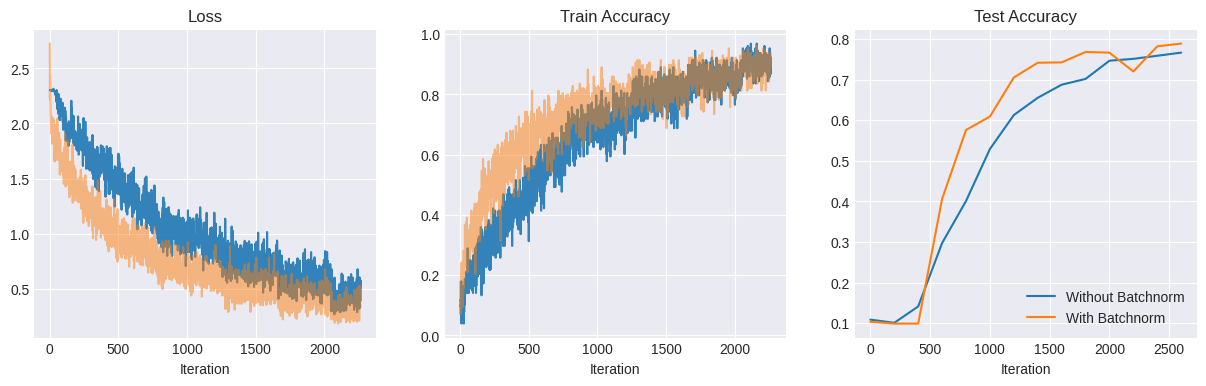

In [ ]:
from deepkit.internal_covariate_shift import (
    santurkar_ics_step,
    loss_landscape_step,
    grad_landscape_step
)

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import clear_output

%matplotlib inline

max_step=20
landscape_step_size=2
grad_step_size=2

try:
  for epoch in range(num_epochs):
      for batch, labels in train_loader:
          batch = jnp.array(batch)
          labels = jnp.array(labels)

          baseline_optimizer_copy = baseline_optimizer.__deepcopy__()
          baseline.train()
          baseline_loss, baseline_activations, baseline_grads = (
              step_fn(baseline, baseline_optimizer, batch, labels)
          )
          baseline_train_losses.append(baseline_loss)

          # Calculate ICS
          baseline_optimizer_copy.model.eval()
          baseline_ics_measures = santurkar_ics_step(baseline_optimizer_copy,
                                           baseline_grads,
                                           batch,
                                           labels)
          baseline_ics_results.append(baseline_ics_measures)

          # Calculate loss landscape
          baseline_copy = baseline.__deepcopy__()
          baseline_copy.eval()
          baseline_loss_range = (
              loss_landscape_step(baseline_copy,
                                  batch,
                                  labels,
                                  baseline_grads,
                                  max_step=max_step,
                                  step_size=landscape_step_size,
                                  lr=lr
             )
          )
          baseline_loss_landscape_ranges.append(baseline_loss_range)

          # Calculate gradient predictiveness
          baseline_grad_range = (
              grad_landscape_step(baseline_copy,
                                  batch,
                                  labels,
                                  baseline_grads,
                                  max_step=max_step,
                                  step_size=grad_step_size,
                                  lr=lr
             )
          )
          baseline_grad_landscape_ranges.append(baseline_grad_range)


          candidate_optimizer_copy = candidate_optimizer.__deepcopy__()
          candidate.train()
          candidate_loss, candidate_activations, candidate_grads = (
              step_fn(candidate, candidate_optimizer, batch, labels)
          )
          candidate_train_losses.append(candidate_loss)

          # Calculate ICS
          candidate_optimizer_copy.model.eval()
          candidate_ics_measures = santurkar_ics_step(candidate_optimizer_copy,
                                           candidate_grads,
                                           batch,
                                           labels)
          candidate_ics_results.append(candidate_ics_measures)

          # Calculate loss landscape
          candidate_copy = candidate.__deepcopy__()
          candidate_copy.eval()
          candidate_loss_range = (
            loss_landscape_step(candidate_copy,
                                batch,
                                labels,
                                candidate_grads,
                                max_step=max_step,
                                step_size=landscape_step_size,
                                lr=lr
             )
          )
          candidate_loss_landscape_ranges.append(candidate_loss_range)

          # Calculate gradient predictiveness
          candidate_grad_range = (
            grad_landscape_step(candidate_copy,
                                batch,
                                labels,
                                candidate_grads,
                                max_step=max_step,
                                step_size=grad_step_size,
                                lr=lr
             )
          )
          candidate_grad_landscape_ranges.append(candidate_grad_range)


          baseline.eval()
          baseline_acc = accuracy(baseline, batch, labels)
          baseline_train_accs.append(baseline_acc)

          candidate.eval()
          candidate_acc = accuracy(candidate, batch, labels)
          candidate_train_accs.append(candidate_acc)

          if i % 200 == 0:
            baseline_test_acc = test_accuracy(baseline, test_loader)
            candidate_test_acc = test_accuracy(candidate, test_loader)
            baseline_test_accs.append(baseline_test_acc)
            candidate_test_accs.append(candidate_test_acc)
            baseline_activations_logger.log(i, baseline_activations)
            candidate_activations_logger.log(i, candidate_activations)
          if i % 20 == 0:
            clear_output(wait=True)
            print(f"iter: {i} | baseline loss: {baseline_loss:0.4f} | "
                  f"candidate loss: {candidate_loss:0.4f} | "
                  f"baseline train acc: {baseline_acc:0.2f} | "
                  f"candidate train acc: {candidate_acc:0.2f} | "
                  f"baseline test acc: {baseline_test_acc: 0.2f} | "
                  f"candidate test acc: {candidate_test_acc: 0.2f}")
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            axes[0].plot(baseline_train_losses, alpha=0.9,
                         label="Without BatchNorm")
            axes[0].plot(candidate_train_losses, alpha=0.5,
                         label="With BatchNorm")
            axes[0].set_title("Loss")
            axes[0].set_xlabel("Iteration")
            axes[1].plot(baseline_train_accs, alpha=0.9,
                         label="Without BatchNorm")
            axes[1].plot(candidate_train_accs, alpha=0.5,
                         label="With BatchNorm")
            axes[1].set_title("Train Accuracy")
            axes[1].set_xlabel("Iteration")
            x = list(range(len(baseline_test_accs)))
            x = [ i*200 for i in x ]
            axes[2].plot(x, baseline_test_accs, label="Without Batchnorm")
            axes[2].plot(x, candidate_test_accs, label="With Batchnorm")
            axes[2].set_title("Test Accuracy")
            axes[2].set_xlabel("Iteration")
            plt.legend()
            plt.show()

          i += 1
except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

## Performance

The BN network clearly performs better than the non-BN one - it converges faster and achieves a higher accuracy on the test set - 86% vs 80% for the non-BN network.

Next, let's analyze the measurements that we gathered during the training process.

## Ioffe et. al ICS i.e. Distributional Shift of the Activations

First, let's plot the activation distributions. From the plots below, it is clear that the BN activations are initally more widely distributed due to BN scaling. However, this changes quickly as training progresses - they remain more stable than the non-BN ones. This matches the results that we obtained back in [Part 1](https://blog.vikrampawar.com/how-batchnorm-works.html). It also seems to contradict the findings of Santurkar et al. (2018), which will require further investigation.


In [13]:
from matplotlib import colormaps as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

layers = [f"conv_{i}" for i in range(10)] + ["fc1", "fc2"]

fig, axs = plt.subplots(6, 2, figsize=(9,12), constrained_layout=True)
axs = axs.flatten()

baseline_activations_logger.files = None
candidate_activations_logger.files = None

def update(frame):
    baseline_activations = baseline_activations_logger[frame]
    candidate_activations = candidate_activations_logger[frame]
    for layer_idx, layer in enumerate(layers):
        axs[layer_idx].cla()
        layer_baseline_activations = baseline_activations[layer].flatten()
        layer_baseline_mean = layer_baseline_activations.mean()
        layer_baseline_std = layer_baseline_activations.std()
        axs[layer_idx].hist(layer_baseline_activations, color=cm["Blues"](50), bins=60, alpha=1.0)

        layer_candidate_activations = candidate_activations[layer].flatten()
        layer_candidate_mean = layer_candidate_activations.mean()
        layer_candidate_std = layer_candidate_activations.std()
        axs[layer_idx].hist(layer_candidate_activations, color=cm["Reds"](90),  bins=60, alpha=0.5)
        axs[layer_idx].set_title(f"{layer} Outputs - Iteration:{frame*200}")

        axs[layer_idx].margins(x=0, y=0)
        axs[layer_idx].set_xlim(-16, 16)
        axs[layer_idx].set_ylim(0, 1e6)
        if layer_idx > 5:
          axs[layer_idx].set_ylim(0, 1e5)
        if layer_idx > 9:
          axs[layer_idx].set_ylim(0, 1e4)
        axs[layer_idx].legend([f"Baseline: {layer_baseline_mean:0.2f} ± {layer_baseline_std:0.2f}",
                             f"Candidate:{layer_candidate_mean:0.2f} ± {layer_candidate_std:0.2f}"])



ani = FuncAnimation(fig, update, frames=len(baseline_activations_logger), interval=300, repeat=True)
plt.close(fig)
video_html = ani.to_html5_video().replace('<video', '<video muted')
HTML(video_html)

## Santurkar et al. ICS i.e. Gradient Shift

Rather than the activations themselves, this definition measures the change in gradient norms for each layer before and after the previous layers are updated:

Mathematically, internal covariate shift (ICS) of activation $i$ at time $t$ is defined as $||G_{t,i} − G^′_{t,i}||^2$, where
$
\begin{align}
G_{t,i} &= ∇_{W^{(t)}_i} \mathcal{L}(W_{1}^{(t)},..., W^{(t)}_k ; x(t), y(t)) \\
G^′_{t,i} &= ∇_{W^{(t)}_i} \mathcal{L}(W^{(t+1)}_1 ,..., W^{(t+1)}_{i−1}, W^{(t)}_i, W^{(t)}_{i+1},..., W^{(t)}_k; x(t), y(t)).
\end{align}
$

This is more of an *operational* definition that measures the impact on the gradient of a particular layer due to covariate shift. It is useful because the gradient is ultimately what impacts learning - a sensitive loss landscape may cause a significant change in the gradient of a layer even without significant changes in its inputs. Conversely, a less sensitive loss landscape may cause little change in the gradient inspite of significant changes to the inputs.


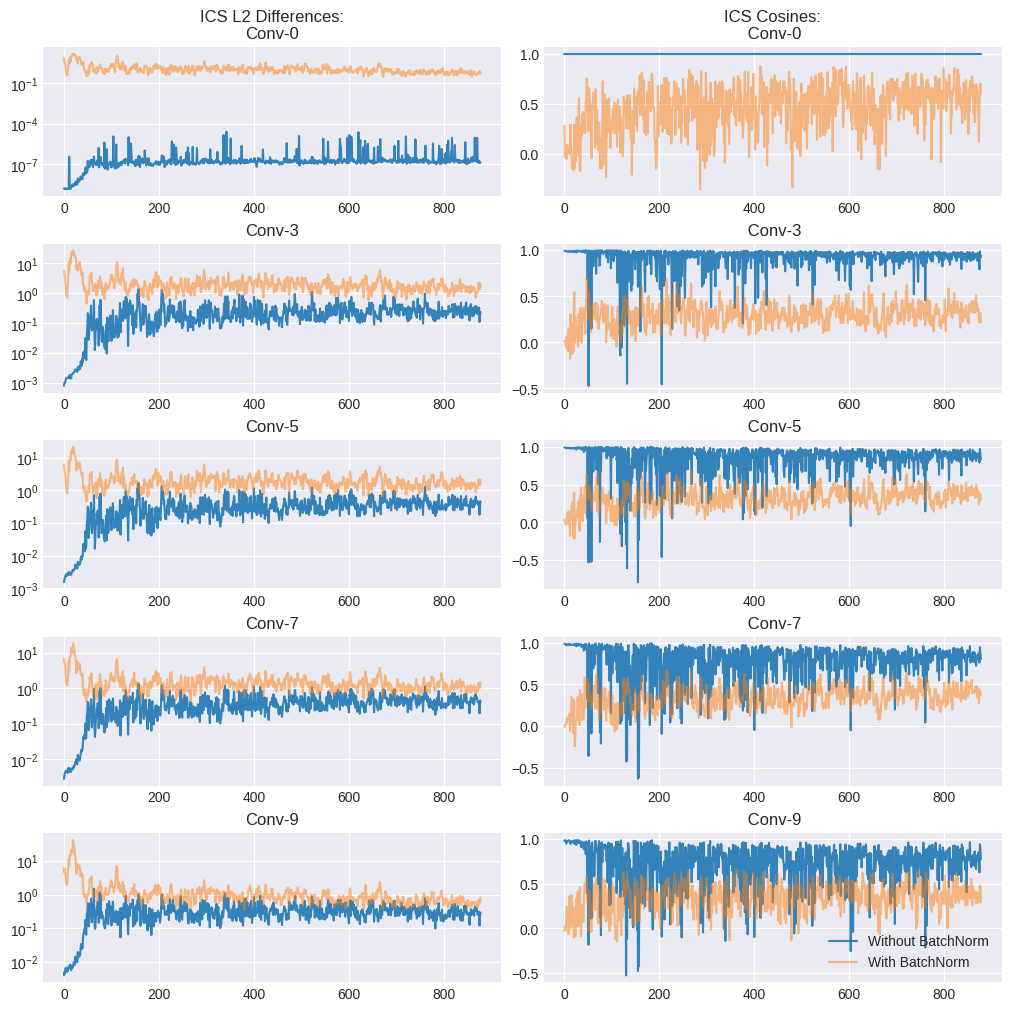

In [14]:
conv_layer_ids = [0,3,5,7,9]

fig, axes = plt.subplots(5, 2, figsize=(10,10), constrained_layout=True)

for row_id, conv_layer_id in enumerate(conv_layer_ids):

  baseline_kernel_ics_l2_norms = [ n[conv_layer_id][0].conv.kernel.value
                                  for n in baseline_ics_results ]
  candidate_kernel_ics_l2_norms = [ n[conv_layer_id][0].conv.kernel.value
                                   for n in candidate_ics_results ]

  axes[row_id, 0].plot(baseline_kernel_ics_l2_norms, label="Without BatchNorm", alpha=0.9)
  axes[row_id, 0].plot(candidate_kernel_ics_l2_norms, label="With BatchNorm", alpha=0.5)
  axes[row_id, 0].set_yscale('log')
  title = ""
  if row_id == 0:
    title += f"ICS L2 Differences:\n"
  title += f"Conv-{conv_layer_id}"
  axes[row_id, 0].set_title(title)


  baseline_kernel_ics_cosines =  [ n[conv_layer_id][1].conv.kernel.value
                                  for n in baseline_ics_results ]
  candidate_kernel_ics_cosines = [ n[conv_layer_id][1].conv.kernel.value
                                  for n in candidate_ics_results ]

  axes[row_id, 1].plot(baseline_kernel_ics_cosines, label="Without BatchNorm", alpha=0.9)
  axes[row_id, 1].plot(candidate_kernel_ics_cosines, label="With BatchNorm", alpha=0.5)
  title = ""
  if row_id == 0:
    title += f"ICS Cosines:\n"
  title += f" Conv-{conv_layer_id}"
  axes[row_id, 1].set_title(title)



plt.legend()
plt.show()


Ideally, the L2 differences ($||G_{t,i} − G^′_{t,i}||^2$) should be $0$ while the cosines $\frac{\langle G_{t,i},G^′_{t,i}\rangle}{||G_{t,i}||||G^′_{t,i}||}$ should be 1, indicating zero covariate shift. In the plots above, it is clear that the BN network performs worse in terms of L2 differences than the non-BN network. The cosine values for the BN network tend to be higher on average but more consistent than the non-BN one.

One way to interpret these results would be that despite the lower distributional ICS shift due to BN, the actual impact on gradient updates isn't obvious. This might be because the underlying cause for the effectiveness of BN is not ICS, but the smoothing effect on the loss landscape itself. 

## Loss Landscape Smoothness i.e. Lipschitzness

Lipschnitzness can be considered as a tight upper bound the steepness of a function. It is defined as:

$|| f(x) - f(y) || \leq L|| x - y ||$ for all $x,y \in \mathbb{R}^n$

where $L$ is the Lipschitz constant.

If $f(x)$ is the loss function, smaller $L$ indicates a 'flatter' loss surface. This is hard to measure because it involves an intractable computation over all pairs $(x, y)$. However, we can approximate it by taking a few steps in the gradient direction at every point in the optimization trajectory and measuring $|| f(x^`) - f(x) ||$ at each step.

In simple terms, a bumpy loss surface should show larger variation in the loss values along the optimization trajectory, while a smoother one should show smaller variation.


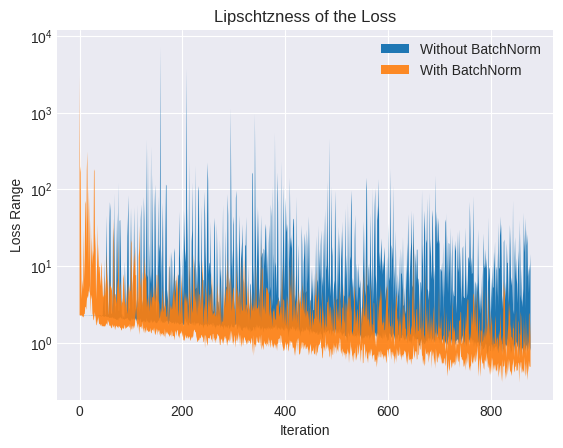

In [15]:
baseline_min_vals = [ s[0] for s in baseline_loss_landscape_ranges ]
baseline_max_vals = [ s[1] for s in baseline_loss_landscape_ranges ]
baseline_x_vals = list(range(len(baseline_min_vals)))

plt.fill_between(baseline_x_vals, baseline_min_vals, baseline_max_vals,
                 alpha=1.0, label="Without BatchNorm")

candidate_min_vals = [ s[0] for s in candidate_loss_landscape_ranges ]
candidate_max_vals = [ s[1] for s in candidate_loss_landscape_ranges ]
candidate_x_vals = list(range(len(candidate_min_vals)))

plt.fill_between(candidate_x_vals, candidate_min_vals, candidate_max_vals,
                 alpha=0.9, label="With BatchNorm")

plt.yscale("log")
plt.legend()
plt.title("Lipschtzness of the Loss")
plt.ylabel("Loss Range")
plt.xlabel("Iteration")
plt.show()

The non-BN model shows significantly higher Lipschitzness, especially earlier in the training run.

## Gradient Predictiveness

Lipschitzness can be defined for the gradient as well and can be approximated by how much the L2 norm of the gradient changes in the gradient direction at a point $x$. This is also called gradient predictiveness. This comes from the idea that a more "predictive" gradient should remain stable and not change significantly in the gradient direction.

### "Effective" $\beta$-Smoothness

This follows the notion of gradient predictiveness above. Similar to Lipschitzness, $\beta$-smoothness provides a tight upper bound on the rate of change of the gradient. A smaller rate of change indicates a smoother loss surface. Formally,

$|| \nabla f(x) - \nabla f(y) || \leq \beta || x - y || \quad \text{for all } x, y \in \mathbb{R}^n $

Once again, this is an intractable calculation, so we can approximate it at each point in the optimization trajectory by taking a few steps in the gradient direction and recording the maximum change in the gradient norm.

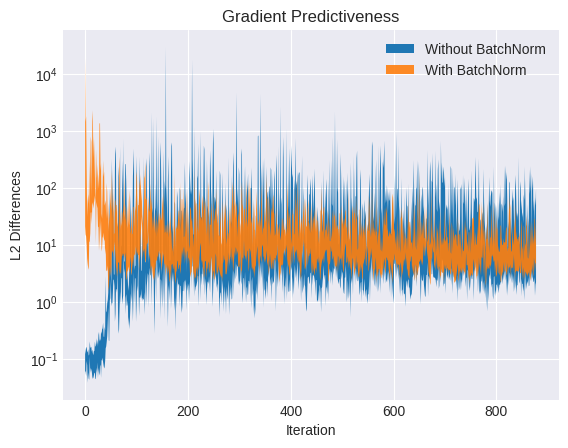

In [16]:
baseline_min_vals = [ s[0] for s in baseline_grad_landscape_ranges ]
baseline_max_vals = [ s[1] for s in baseline_grad_landscape_ranges ]
baseline_x_vals = list(range(len(baseline_min_vals)))

plt.fill_between(baseline_x_vals, baseline_min_vals, baseline_max_vals,
                 alpha=1.0, label="Without BatchNorm")

candidate_min_vals = [ s[0] for s in candidate_grad_landscape_ranges ]
candidate_max_vals = [ s[1] for s in candidate_grad_landscape_ranges ]
candidate_x_vals = list(range(len(candidate_min_vals)))

plt.fill_between(candidate_x_vals, candidate_min_vals, candidate_max_vals,
                 alpha=0.9, label="With BatchNorm")

#plt.ylim(0, 200)
plt.xlabel("Iteration")
plt.ylabel("L2 Differences")
plt.yscale("log")
plt.legend()
plt.title("Gradient Predictiveness")
plt.show()

It is clear from the plot above that gradient predictiveness for the BN network is consistently better (lower is better) throughout the training run. This is especially true earlier in the run.

## More Favorable Initialization

BN leads to more favourable initialization for the weights. Mathematically,

$
|| W_0 - \hat{W}^∗ ||^2 ≤ ||W_0 − W^∗||^2 − \frac{1}{||W^∗||^2} ( ||W^∗||^2 −〈W^∗, W_0〉)^2
$

where $W_0$ is the initial weights and $\hat{W}^*$ and $W^*$ are the nearest local minima for the BN and non-BN networks respectively. The proof for this result is available in Santurkar et. al (2018).

We can test this empirically by measuring the L2 differences between the initial weights and the optima for both networks. 



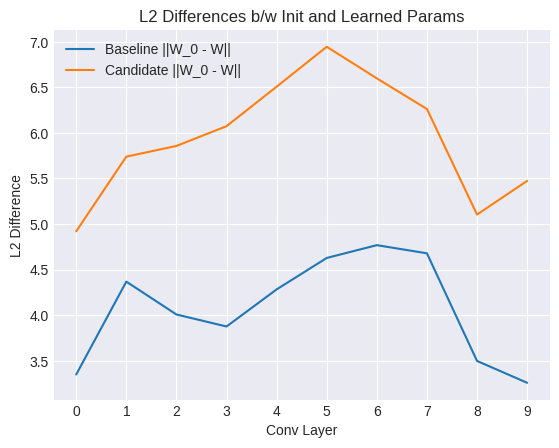

In [17]:
from deepkit import utils


init_norms = []

for conv_id in range(len(baseline_state.convs)):
  w0 = baseline_state.convs[conv_id].conv.kernel.value
  baseline_w = baseline.convs[conv_id].conv.kernel.value
  candidate_w = candidate.convs[conv_id].conv.kernel.value
  ##norm = layer_l2_diff(state.fc1, candidate.fc1)
  #print(norm)
  delta1 = jax.tree_util.tree_map(
    lambda x, y: jnp.sqrt(jnp.sum(jnp.square(x.flatten() - y.flatten()))), w0, baseline_w)
  delta2 = jax.tree_util.tree_map(
    lambda x, y: jnp.sqrt(jnp.sum(jnp.square(x.flatten() - y.flatten()))), w0, candidate_w)
  init_norms.append((conv_id, delta1, delta2))
  #print(f"Conv-{conv_id}: Baseline ||w_0 - w|| {delta1:0.2f}, Candidate ||w_0, w|| {delta2:0.2f})")


x = [ t[0] for t in init_norms ]
baseline_norms = [ t[1] for t in init_norms ]
candidate_norms = [ t[2] for t in init_norms ]
plt.plot(x, baseline_norms, label="Baseline ||W_0 - W||")
plt.plot(x, candidate_norms, label="Candidate ||W_0 - W||")
plt.xticks(x)
plt.xlabel("Conv Layer")
plt.ylabel("L2 Difference")
plt.legend()
plt.title("L2 Differences b/w Init and Learned Params")
plt.show()

As seen in the plot below, the value is consistently smaller for the BN network for all the convolutional layers.

## Conclusion and Future Work

According to the distributional shift definition of ICS, (Ioffe et al. (2015)), we can observe a significant reduction in ICS due to BN, which appears to contradict the results obtained by Santurkar et al.
However, using the Santurkar et al. definition of ICS as gradient shift, the reduction in ICS is not as clear. The effect of BN on distributional ICS may be secondary and largely independent of the performance of BN.
From the loss landscape measurements, it is clear that BN has a smoothing effect on the loss surface, improves gradient predictiveness and leads to more favorable initialization. These may be more fundamental reasons behind its efficacy. 

In the next experiment, we will examine the effect of adding random noise to the layer activations as well as try to reconcile the results for the distributional ICS measurement. We will also delve into the math behind the smoothing theory.


## References

1. Santurkar, S., Tsipras, D., Ilyas, A., & Madry, A. (2018). How does batch normalization help optimization? Advances in Neural Information Processing Systems, 31. https://arxiv.org/abs/1805.11604
2. Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In Proceedings of the 32nd International Conference on Machine Learning (ICML) (pp. 448–456). https://arxiv.org/abs/1502.03167
3. Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition [Preprint]. arXiv. https://arxiv.org/abs/1409.1556


